In [131]:
import matplotlib.pyplot as plt
import csv
import operator as op

class CsvReaderHeading:
    def __init__(self, file, **csvreader_kwargs):
        self.reader = csv.reader(file, **csvreader_kwargs)
        self.header = next(self.reader)
        self.indices = range(len(self.header))

    def __iter__(self):
        return self
        
    def __next__(self):
        as_list = next(self.reader)
        return { self.header[i]: as_list[i] for i in self.indices }

class CsvTable:
    def __init__(self, itr):
        self.itr = itr
    
    def populate(self):
        self.rows = list(self.itr)
        self.keys = self.rows[0].keys()
    
    @property
    def cols(self):
        return { k: [ int(row[k]) for row in self.rows ] for k in self.keys }
    
    @property
    def freqs(self):
        return {k: frequencies(self.cols[k]) for k in self.keys }

def frequencies(xs):
    result = {}
    for x in xs:
        if x not in result:
            result[x] = 0
        result[x] += 1
    return result

In [132]:
table = None
with open("log.csv", "r") as f:
    reader = CsvReaderHeading(f)
    table = CsvTable(reader)
    table.populate()

In [184]:
def plot_histogram(x, xlabel, title, line=None):
    freqs = frequencies(x)
    items = list(freqs.keys())
    items.sort()
    values = [ freqs[item] for item in items ]
    plt.bar(items, values, color="darkblue")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.title(title)
    if line != None:
        height = max(values)
        start = min(items)
        plt.axline([line, 0], [line, height], color="grey", linewidth=3, linestyle="dashed")
    plt.show()

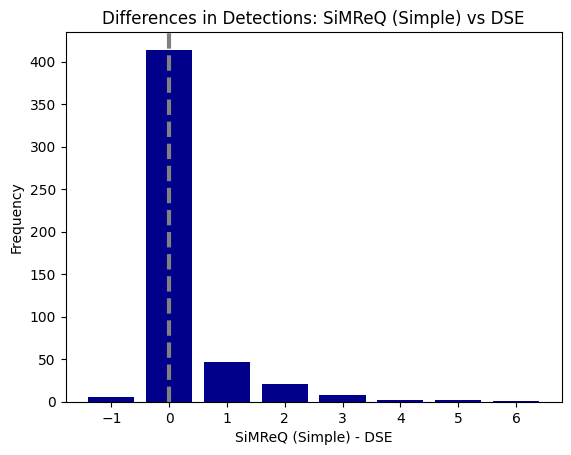

In [189]:
plot_histogram(map(op.sub, table.cols["SiMReQ (Simple)"], table.cols["DSE"]), "SiMReQ (Simple) - DSE", "Differences in Detections: SiMReQ (Simple) vs DSE", line=0)